Zeitreihen Vorhersage: PCA: jeweils Fortsetzen, dann Rückprojektion, Validierung mit Backtest (Train / Test Split bei 75% Zeit)
- Datensatz: DAX oder Lufthansa Performance Daten
- Idee: Nutze die erste Hälfte der Daten um PCA zu machen, dabei entstehen lineare Funktionen, die man fortsetzen kann
- Damit kann der Zukünftige Kursverlauf vorhergesagt werden, und diese Vorhersage kann mit den tatsächlichen Daten verglichen werde

Was hier passiert ist letztlich bloß eine lineare regression...

In [109]:
import pandas as pd
from sklearn.decomposition import PCA

dax = pd.read_csv("../data/dax_performance.csv", )
for col in ["Price", "Open", "High", "Low"]:
    dax[col] = dax[col].str.replace(",", "").astype(float)

dax["Vol."] = dax["Vol."].str.replace("M", "").astype(float) * 1e6
dax["Change %"] = dax["Change %"].str.replace("%", "").astype(float) / 100.0
dax["Date"] = pd.to_datetime(dax["Date"], format="%m/%d/%Y")

dax

,Date,Price,Open,High,Low,Vol.,Change %
0,2025-08-25,24290.29,24216.50,24298.77,24213.00,7010000.0,-0.0030
1,2025-08-22,24363.09,24254.81,24444.41,24222.54,44810000.0,0.0029
2,2025-08-21,24293.34,24274.42,24306.06,24179.91,39350000.0,0.0007
3,2025-08-20,24276.97,24252.72,24369.87,24217.51,44780000.0,-0.0060
4,2025-08-19,24423.07,24357.23,24441.00,24283.55,43710000.0,0.0045
...,...,...,...,...,...,...,...
8751,1990-01-26,1798.22,1798.22,1798.22,1798.22,NaN,0.0037
8752,1990-01-25,1791.52,1791.52,1791.52,1791.52,NaN,0.0228
8753,1990-01-24,1751.62,1751.62,1751.62,1751.62,NaN,-0.0187
8754,1990-01-23,1785.00,1785.00,1785.00,1785.00,NaN,-0.0012


[[ 0.8067875   0.59084171]
 [ 0.59084171 -0.8067875 ]]
[0.96341139 0.03658861]


C:\Users\fschuller\AppData\Local\Temp\ipykernel_12640\2431746504.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pc1_pred = m * dax[["day"]] + float(dax[dax["day"] == 0]["Price"])


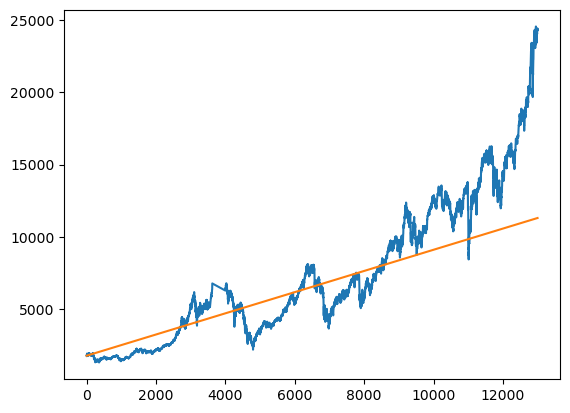

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# für den vergleich mit der geometrischen Brownschen Bewegung später
dax["logreturn"] = np.append(np.diff(np.log(dax["Price"].to_numpy())), 0)

start_date = dax["Date"][dax.shape[0] - 1]
dax["day"] = (dax["Date"] - start_date).dt.days

pca = PCA(n_components=2).fit(dax[["Price", "day"]])
print(pca.components_)
print(pca.explained_variance_ratio_)

m = pca.components_[0][1] / pca.components_[0][0]
pc1_pred = m * dax[["day"]] + float(dax[dax["day"] == 0]["Price"])

plt.plot(dax[["day"]], dax[["Price"]])

plt.plot(dax[["day"]], pc1_pred)

[[17314.0109357   4744.22744386]
 [17370.97254079  4789.66108278]
 [17314.10827075  4749.25666109]
 ...
 [-8549.07604556  1913.25832201]
 [-8522.73632041  1933.78740575]
 [-8521.64904412  1935.82314401]]


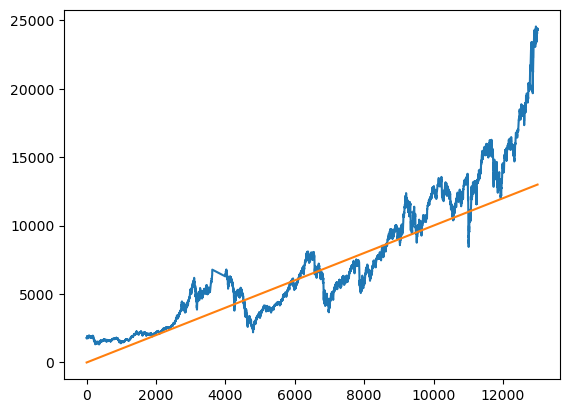

In [83]:
reduced = pca.transform(dax[["Price", "day"]])

print(reduced)

pred = pca.inverse_transform(reduced)

plt.plot(dax[["day"]], pred.transpose()[0])
plt.plot(dax[["day"]], pred.transpose()[1])

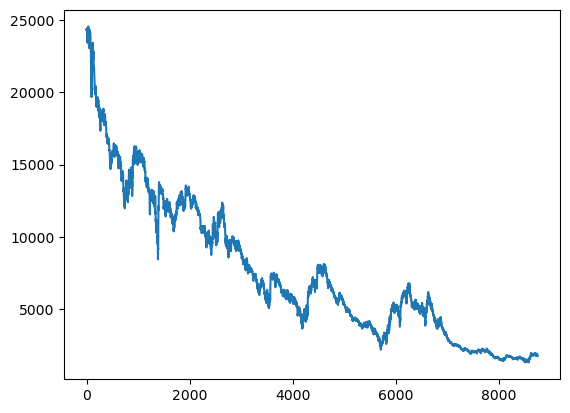

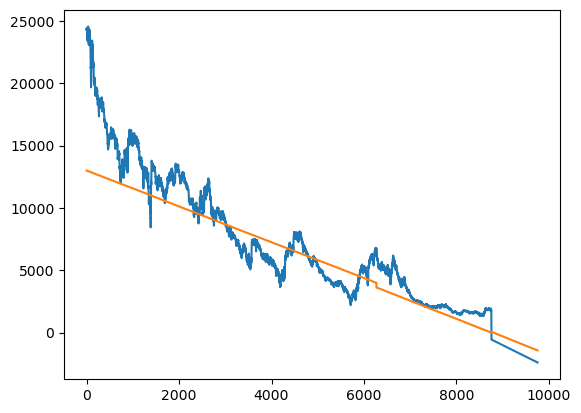

In [108]:
from sklearn.linear_model import LinearRegression

t = np.arange(len(reduced)).reshape(-1, 1)

models = []
for i in range(reduced.shape[1]):
    y = reduced[:, i]
    reg = LinearRegression().fit(t, y)
    models.append(reg)


h = 1000
t_future = np.arange(len(reduced), len(reduced)+h).reshape(-1, 1)

dax_pca_pred_new = np.zeros((h, reduced.shape[1]))
for i, reg in enumerate(models):
    dax_pca_pred_new[:, i] = reg.predict(t_future)


dax_pca_pred = np.append(reduced, dax_pca_pred_new, axis=0)

future = pca.inverse_transform(dax_pca_pred)

plt.plot(pred.transpose()[0])

plt.show()

plt.plot(future.transpose()[0])
plt.plot(future.transpose()[1])